In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
%matplotlib inline  

In [2]:
df = pd.read_excel('wear_others.xlsx', sheet_name= 'Sheet1')

df['time'] = ''
df.loc[df['Quarter'] == 1, 'time'] = '01-01'
df.loc[df['Quarter'] == 2, 'time'] = '04-01'
df.loc[df['Quarter'] == 3, 'time'] = '07-01'
df.loc[df['Quarter'] == 4, 'time'] = '10-01'
df['Year-Q'] = df['Year'].astype(str) + '-' + df['time'].astype(str)
df['Year-Q'] = pd.to_datetime(df['Year-Q'])

In [3]:
def take_data(data, market = 'All', category = 'All'):
  
  if (market == 'All') & (category == 'All'):
    return data
  else:
    data = data.loc[ (data['Market'] == market) & 
                   (data['Category'] == category)]
  return data

In [4]:
data = take_data(df, 'Hong Kong', 'A')
# data = take_data(df, 'All', 'All')
data

,Year,Quarter,Vendor,Brand,Category,Market,Units,time,Year-Q
152,2020,4,Others,Others,A,Hong Kong,288,10-01,2020-10-01
157,2020,4,Others,Others,A,Hong Kong,67,10-01,2020-10-01
160,2020,4,Others,Others,A,Hong Kong,507,10-01,2020-10-01
162,2020,4,Others,Others,A,Hong Kong,123,10-01,2020-10-01
167,2020,4,Others,Others,A,Hong Kong,185,10-01,2020-10-01
...,...,...,...,...,...,...,...,...,...
5202,2022,4,Others,Others,A,Hong Kong,2866,10-01,2022-10-01
5203,2022,4,Others,Others,A,Hong Kong,1437,10-01,2022-10-01
5204,2022,4,Others,Others,A,Hong Kong,4534,10-01,2022-10-01
5205,2022,4,Others,Others,A,Hong Kong,2256,10-01,2022-10-01


In [5]:
from fbprophet import Prophet
import logging

def create_model(train_prophet):
    
    logging.getLogger("cmdstanpy").disabled = True
    model = Prophet( 
                    yearly_seasonality=20, 
                    weekly_seasonality=False, 
                    daily_seasonality=True,
                    # seasonality_mode = 'multiplicative', 
                    # changepoint_range = 0.1, 
                    # n_changepoint
                    interval_width = 0.9,
                    growth='logistic', 
                    holidays_prior_scale=0.05
                    )
    
    model.add_seasonality('quarterly', period=91.25, 
                          fourier_order= 12, mode='additive')

    model.fit(train_prophet, algorithm='LBFGS') 
    logging.getLogger("cmdstanpy").disabled=False    
    return model 

In [6]:
def revision(a, b, rate):
  

  a['fix'] = 0
  a['fix'][0] = b['Units'][-1:] * rate
  
  for i in range( len(a['fix']) - 1):
    a['fix'][i + 1] = a['fix'][i] * a['Units'][i + 1] / a['Units'][i]
    
  a['Units'] = a['fix']
  
  return a, b

In [7]:
def train_procession(val):
    
    df = val[['Year-Q', 'Units']]
    y = df.groupby(['Year-Q'])['Units'].sum().to_frame()
    y.sort_index(inplace=True)
    
    train = y[:int(1*(len(y)))]
    scaler = MinMaxScaler(feature_range = [0, 1]).fit(train)
    train_S = scaler.transform(train)
    train['ds'] = train.index
    
    train_prophet = pd.DataFrame()
    train_prophet['ds'] = train.index
    train_prophet['y'] = train_S

    train_prophet['cap'] = 1
    train_prophet['floor'] = 0.01
    
    return train_prophet, train, scaler


In [8]:
ind_list = []


for ind, val in data.groupby(['Category', 'Market']):

    train_prophet, train, scaler = train_procession(val)
    model = create_model(train_prophet)

    future = model.make_future_dataframe( periods = 4, freq = 'QS') 
    future['cap'] = 1
    future['floor'] = 0.01
    forecast = model.predict(future)
    forecast_prophet = forecast.set_index('ds')
    pred = forecast_prophet['yhat'][-4: ].to_frame()
    pred = scaler.inverse_transform(pred)
    test_time = forecast_prophet.index[-4: ]

    res = pd.DataFrame()
    res['ds'] = test_time
    res['Units'] = np.abs(pred.astype(int))
    res['Category'] = ind[0]
    res['Market'] = ind[1]
    
    
    
    # b_list = ['Rest of Western Europe', 'Chile', 
    #           'Colombia', 'Peru', 'Rest of Latin America', 
    #           'Rest of Central & Eastern Europe']
    
    # if ((ind[0] == 'C') & (ind[1] == 'Egypt')):
        
    #     res, _ = revision(res, train, 0.9)
    #     ind_list.append(res)    
    
    # elif ((ind[0] == 'B') & (ind[1] in b_list)):
        
    #     res, _ = revision(res, train, 1.05)
    #     ind_list.append(res)    
        
    # else:
    #     ind_list.append(res)
    res, _ = revision(res, train, 0.95)
    ind_list.append(res)

/Users/weidaw/opt/anaconda3/envs/weida/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


Initial log joint probability = -3.40413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       13.8053   5.87198e-05       50.5733   1.165e-06       0.001      149  LS failed, Hessian reset 
      97       13.8084   6.10778e-09        50.563      0.4633      0.4633      192   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/weidaw/opt/anaconda3/envs/weida/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/weidaw/opt/anaconda3/envs/weida/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
final = pd.concat(ind_list)
final.drop('fix', axis= 1, inplace= True)
final.to_excel('res.xlsx')

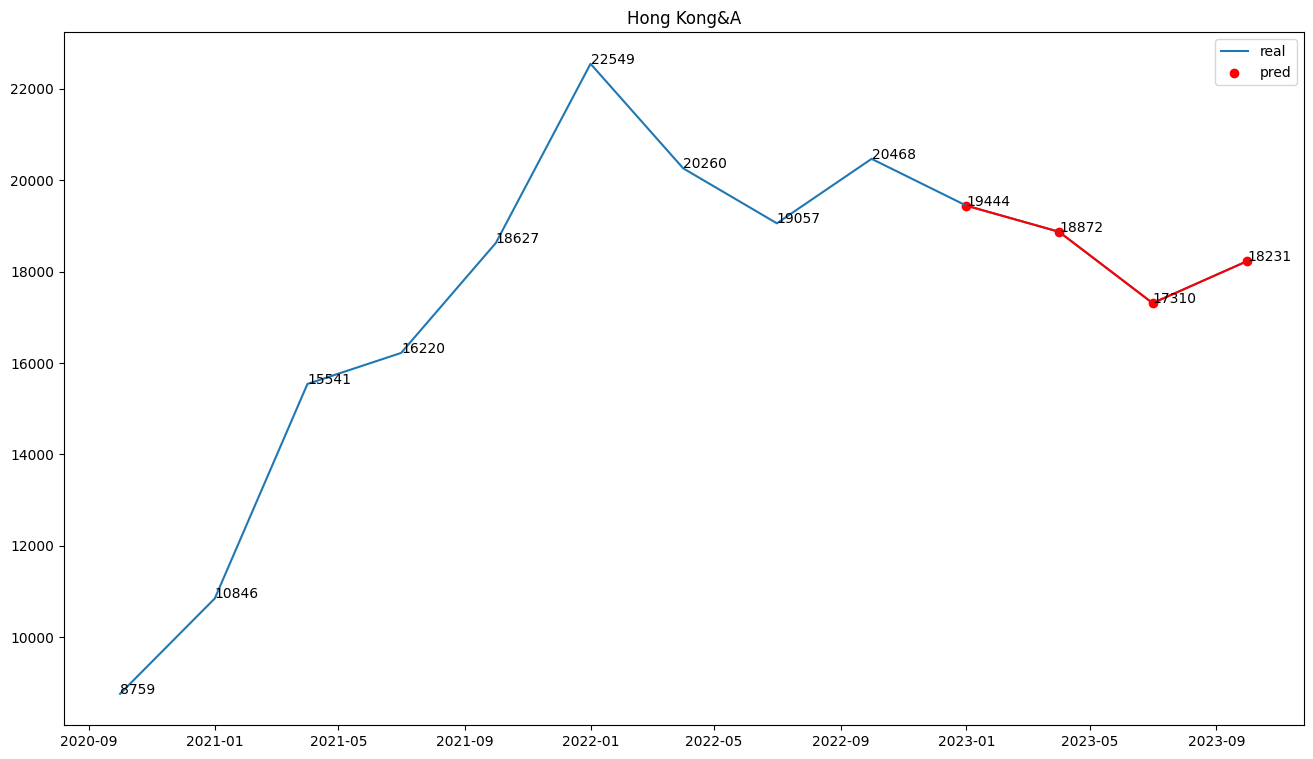

In [12]:
def one_show(market, category, org_data, fin_data ):

  a = fin_data.rename( columns= {'ds': 'Year-Q', 'yhat': 'Units'})
  b = org_data.groupby('Year-Q')['Units'].sum().to_frame().reset_index()
                       
  df_test = pd.concat([b ,a])
  
  plt.figure( figsize= (16, 9))
  x = df_test['Year-Q'].to_list()
  y = df_test['Units'].to_list()
  txt = df_test['Units'].astype(str).to_list()

  for i in range(len(x)):
    plt.annotate(txt[i], xy = (x[i], y[i]))
    
  plt.plot(df_test['Year-Q'], df_test['Units'], label = 'real')
  plt.plot(a['Year-Q'], a['Units'], color = 'red')
  plt.scatter(a['Year-Q'], a['Units'], color = 'red', label = 'pred')
  plt.title( market + '&' + category)
  plt.legend()
  plt.show()

one_show('Hong Kong', 'A', data, final)

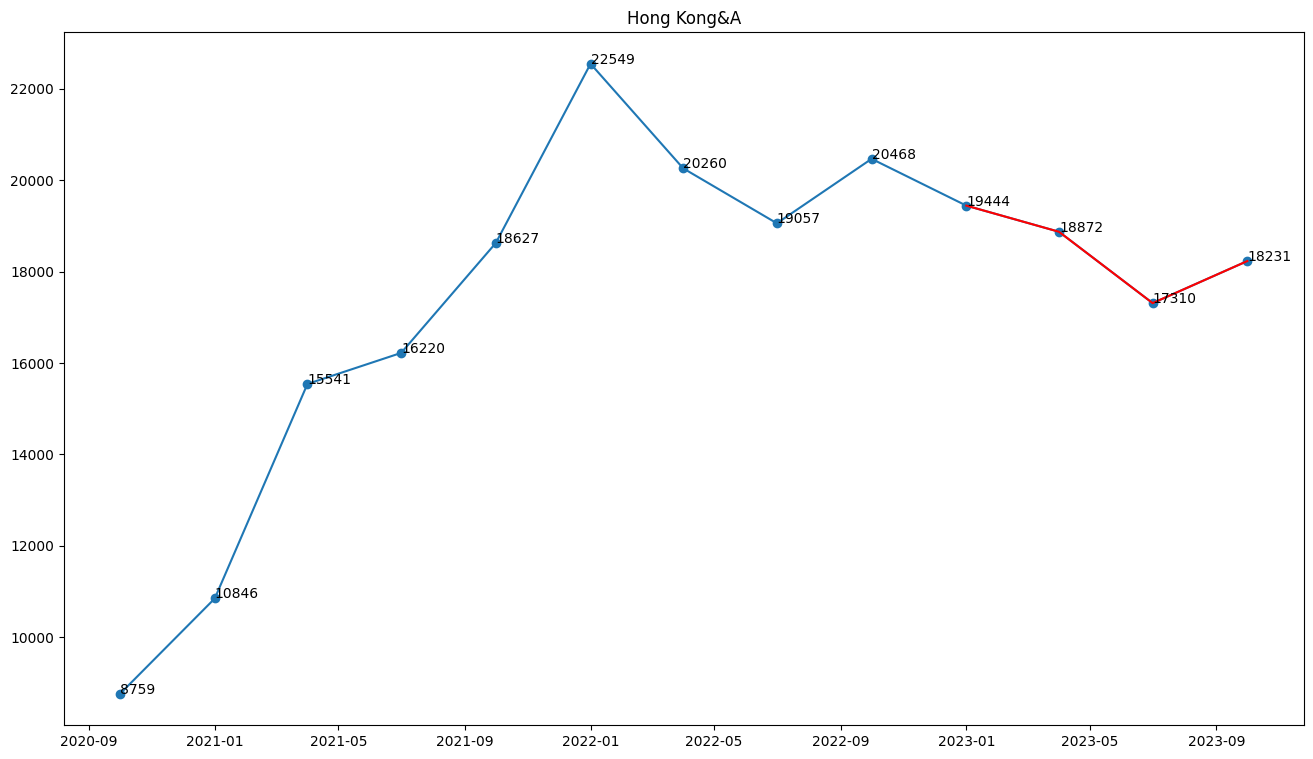

In [25]:
for ind, val in final.groupby(['Category', 'Market']):
    
    a = final.loc[ (final['Market'] == ind[1]) & (final['Category'] == ind[0])]
    a = a.rename( columns= {'ds': 'Year-Q', 'yhat': 'Units'})
    b = data.loc[ (data['Market'] == ind[1]) & (data['Category'] == ind[0])].\
        groupby('Year-Q')['Units'].sum().to_frame().reset_index()
    df_test = pd.concat([b ,a])
    plt.figure( figsize= (16, 9))

    plt.xticks = df_test['Year-Q']
    plt.scatter(df_test['Year-Q'], df_test['Units'])
    
    x = df_test['Year-Q'].to_list()
    y = df_test['Units'].to_list()
    txt = df_test['Units'].astype(str).to_list()

    for i in range(len(x)):
        plt.annotate(txt[i], xy = (x[i], y[i]))
            
    plt.plot(df_test['Year-Q'], df_test['Units'])
    plt.plot(a['Year-Q'], a['Units'], color = 'red')

    plt.title(ind[1] + '&' + ind[0])
    plt.savefig('img/' + ind[1] + '&' + ind[0] + '.png')
        